## Project Background
Autism Spectrum Disorder (ASD) affects communication and behavior. Early identification and intervention can significantly improve outcomes. This project aims to identify individuals who may be at higher risk for ASD based on commonly collected screening data (e.g., questionnaire responses, basic demographic information).

## Objective
The goal is to create a ML Ops tool that can do early detection for potential cases towards further clinical assessment, potentially speeding up the screening process and directing resources more effectively. This tool will predict the likelihood of an individual having Autism Spectrum Disorder (ASD) based on screening questionnaire data and demographic features, aiming for high sensitivity (recall) to minimize missed cases. This is a supervised binary classification problem (ASD vs. No ASD).

## Technical Background:
The model will use data from screenings to learn patterns in these features to distinguish between individuals diagnosed with ASD and those without.Technical challenges may involve preprocessing potentially imbalanced data, and ensuring fairness across different demographic groups by analyzing key metrics.
Evaluation will focus on classification performance metrics relevant to screening:
Primary Metrics: Recall (Sensitivity), AUC, PRC, Accuracy, Precision, F1-Score

Secondary Metrics: DIR, Relative Error, Force Plots. Correlation Plots.

Business/Clinical Relevance: Quantify the model's potential impact by simulating its use on a test set: calculate the percentage of true positive cases identified within the top X% of model predictions (e.g., top 20%), representing potential to accelerate workload for clinicians focusing on these high-risk individuals.


### Import libraries

In [24]:
import numpy as np 
import pandas as pd 
import boto3
import sagemaker
from pyathena import connect
import matplotlib.pyplot as plt
import seaborn as sns

### Load test and train dataset

In [2]:
train_df = pd.read_csv('./Autism_Prediction/train.csv')
test_df = pd.read_csv('./Autism_Prediction/test.csv')

In [3]:
train_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [4]:
test_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
0,1,1,1,0,0,1,1,0,0,1,...,15.599481,m,White-European,yes,no,India,no,12.399055,18 and more,Self
1,2,1,0,0,0,0,0,0,1,0,...,27.181099,m,Asian,no,no,Mexico,no,6.551598,18 and more,Self
2,3,1,1,1,0,1,1,0,1,1,...,31.643906,m,White-European,yes,no,Egypt,no,3.180663,18 and more,Self
3,4,0,0,0,0,0,0,0,0,0,...,25.369210,m,?,no,no,India,no,2.220766,18 and more,Self
4,5,0,0,0,1,0,0,0,0,0,...,9.078580,m,?,no,no,Italy,no,7.252028,18 and more,Self


### Create AWS session

In [8]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [ ]:
### Create and Push Data to S3 bucket

In [9]:
s3_private_path_tsv = "s3://{}/autism_prediction/tsv".format(bucket)
print(s3_private_path_tsv)

s3://sagemaker-us-east-1-672518276407/autism_prediction/tsv


In [10]:
!aws s3 cp "Autism_Prediction/test.csv" $s3_private_path_tsv/
!aws s3 cp "Autism_Prediction/train.csv" $s3_private_path_tsv/

upload: Autism_Prediction/test.csv to s3://sagemaker-us-east-1-672518276407/autism_prediction/tsv/test.csv
upload: Autism_Prediction/train.csv to s3://sagemaker-us-east-1-672518276407/autism_prediction/tsv/train.csv


### Create ASW S3 Athena Database

In [12]:
database_name = "dso_asd_v1"
s3_staging_dir = "s3://sagemaker-us-east-1-672518276407/autism_prediction/tsv"
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS dso_asd_v1


/tmp/ipykernel_1516/873326040.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


In [16]:
statement = "SHOW DATABASES LIKE 'dso_asd_v1'"

df_show = pd.read_sql(statement, conn)
df_show.head(10)

/tmp/ipykernel_1516/2483888340.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,dso_asd_v1


In [17]:
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [19]:
import awswrangler as wr

# Database name
database_name = "dso_asd_v1_parquet"

# Create the Glue database if it doesn't exist
try:
    wr.catalog.create_database(name=database_name)
    print(f"Database '{database_name}' created successfully or already exists.")
except Exception as e:
    print(f"Error creating database: {e}")

Database 'dso_asd_v1_parquet' created successfully or already exists.


In [20]:
# S3 bucket and file path for Parquet
bucket_name = "sagemaker-us-east-1-672518276407"
parquet_path = f"s3://{bucket_name}/autism_prediction/parquet/asd_dataset.parquet" 

# Save DataFrame as Parquet to S3
try:
    wr.s3.to_parquet(
        df=train_df,
        path=parquet_path,
        dataset=True,
        mode="overwrite",
        database=database_name,
        table="asd_parquet"
    )
    print(f"Data uploaded successfully to {parquet_path} as Parquet.")
except Exception as e:
    print(f"Error uploading DataFrame to S3: {e}")

2025-06-01 22:33:56,498	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 411021312 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.81gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-06-01 22:33:57,768	INFO worker.py:1821 -- Started a local Ray instance.


Data uploaded successfully to s3://sagemaker-us-east-1-672518276407/autism_prediction/parquet/asd_dataset.parquet as Parquet.


In [21]:
# List all tables in the specified database
try:
    tables = list(wr.catalog.get_tables(database=database_name))
    print("Tables in the database:")
    for table in tables:
        print(f"- {table['Name']}")
except Exception as e:
    print(f"Error retrieving tables: {e}")

Tables in the database:
- asd_parquet


### Query the data from AWS Athena DB

In [23]:
# Query the table to check if the data is loaded
try:
    query = f"SELECT * FROM {database_name}.asd_parquet LIMIT 5"
    df_sample = wr.athena.read_sql_query(query, database=database_name)
    print("Data from the ASD Athena table:")
    print(df_sample)
except Exception as e:
    print(f"Error querying table: {e}")

Data from the ASD Athena table:
   id  a1_score  a2_score  a3_score  a4_score  a5_score  a6_score  a7_score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   a8_score  a9_score  ...  gender       ethnicity jaundice austim  \
0         0         1  ...       f               ?       no     no   
1         0         0  ...       m               ?       no     no   
2         1         1  ...       m  White-European       no    yes   
3         0         0  ...       f               ?       no     no   
4         0         0  ...       m               ?       no     no   

   contry_of_res used_app_before     result     age_desc  relation class

### Plotting diagrams

<Axes: xlabel='Class/ASD', ylabel='age'>

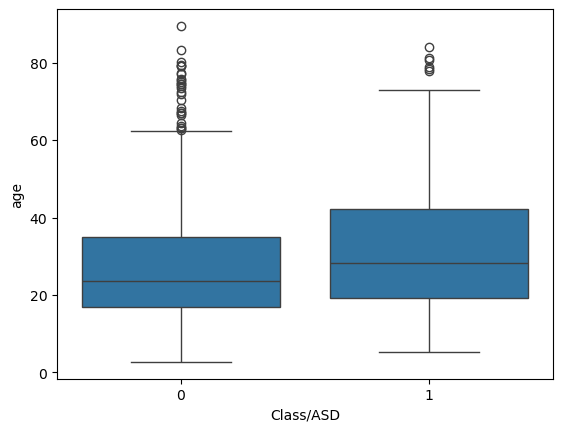

In [25]:
sns.boxplot(x = train_df['Class/ASD'], y = train_df['age'])

<Axes: xlabel='age', ylabel='Count'>

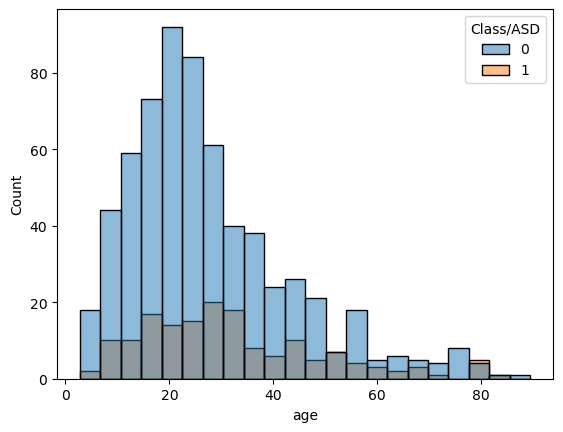

In [26]:
sns.histplot(x = train_df['age'], hue = train_df['Class/ASD'])

<Axes: xlabel='Class/ASD', ylabel='result'>

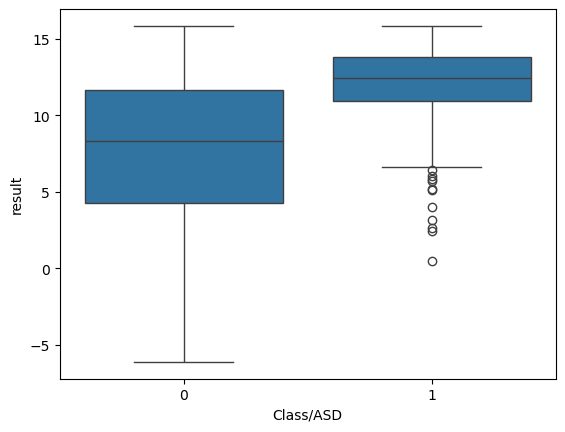

In [27]:
sns.boxplot(x = train_df['Class/ASD'], y = train_df['result'])